#Run Simulation

In [9]:
!pip install git+https://github.com/ichironakamoto/Japan.git

  Cloning https://github.com/ichironakamoto/Japan.git to /tmp/pip-req-build-aa3conua
  Running command git clone -q https://github.com/ichironakamoto/Japan.git /tmp/pip-req-build-aa3conua
  Created wheel for covid19-inference: filename=covid19_inference-0.0.10-cp36-none-any.whl size=27625 sha256=fadda902a0acb2bab5d9e83a878665ca0ec06f5d537efa66f74bfe81ec404173
  Stored in directory: /tmp/pip-ephem-wheel-cache-k8kp9sot/wheels/1e/a5/16/7d019c629951d7e8b52c76c794e547a19333680b3c6dbac3bd
Successfully built covid19-inference


In [0]:
import datetime
import time as time_module
import sys
import os 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import theano
import matplotlib
import pymc3 as pm
import pickle

try: 
    import covid19_inference as cov19
except ModuleNotFoundError:
    sys.path.append('../..')
    import covid19_inference as cov19

path_to_save = '../../figures/'

In [0]:
def delay_cases(new_I_t, len_new_I_t, len_new_cases_obs , delay, delay_arr):
    """
    Delays the input new_I_t by delay and return and array with length len_new_cases_obs
    The initial delay of the output is set by delay_arr. 
    
    Take care that delay is smaller or equal than delay_arr, otherwise zeros are 
    returned, which could potentially lead to errors

    Also assure that len_new_I_t is larger then len(new_cases_obs)-delay, otherwise it 
    means that the simulated data is not long enough to be fitted to the data.
    """
    delay_mat = make_delay_matrix(n_rows=len_new_I_t, 
                                  n_columns=len_new_cases_obs, initial_delay=delay_arr)
    inferred_cases = interpolate(new_I_t, delay, delay_mat)
    return inferred_cases 

def make_delay_matrix(n_rows, n_columns, initial_delay=0):
    """
    Has in each entry the delay between the input with size n_rows and the output
    with size n_columns
    """
    size = max(n_rows, n_columns)
    mat = np.zeros((size, size))
    for i in range(size):
        diagonal = np.ones(size-i)*(initial_delay + i)
        mat += np.diag(diagonal, i)
    for i in range(1, size):
        diagonal = np.ones(size-i)*(initial_delay - i)
        mat += np.diag(diagonal, -i)
    return mat[:n_rows, :n_columns]

def interpolate(array, delay, delay_matrix):
    interp_matrix = tt.maximum(1-tt.abs_(delay_matrix - delay), 0)
    interpolation = tt.dot(array,interp_matrix)
    return interpolation


In [12]:
import pymc3 as pm
import theano.tensor as tt
import theano
import datetime
import time

confirmed_cases = cov19.get_jhu_confirmed_cases()

date_data_begin = datetime.date(2020,3,1)
date_data_end = datetime.date(2020,3,15)
num_days_to_predict = 28

diff_data_sim = 16 # should be significantly larger than the expected delay, in 
                   # order to always fit the same number of data points.
date_begin_sim = date_data_begin - datetime.timedelta(days = diff_data_sim)
format_date = lambda date_py: '{}/{}/{}'.format(date_py.month, date_py.day,
                                                 str(date_py.year)[2:4])
date_formatted_begin = format_date(date_data_begin)
date_formatted_end = format_date(date_data_end)

cases_obs =  np.array(
    confirmed_cases.loc[confirmed_cases["Country/Region"] == "Germany", 
                        date_formatted_begin:date_formatted_end])[0]

print(cases_obs)
#cases_obs = np.concatenate([np.nan*np.ones(diff_data_sim), cases_obs])
print('Cases yesterday ({}): {} and '
      'day before yesterday: {}'.format(date_data_end.isoformat(), *cases_obs[:-3:-1]))
num_days = (date_data_end - date_begin_sim).days
date_today = date_data_end + datetime.timedelta(days=1)
# ------------------------------------------------------------------------------ #
# model setup and training
# ------------------------------------------------------------------------------ #
np.random.seed(0)

def SIR_model(λ, μ, S_begin, I_begin, N):
    new_I_0 = tt.zeros_like(I_begin)
    def next_day(λ, S_t, I_t, _):
        new_I_t = λ/N*I_t*S_t
        S_t = S_t - new_I_t
        I_t = I_t + new_I_t - μ * I_t
        return S_t, I_t, new_I_t
    outputs , _  = theano.scan(fn=next_day, sequences=[λ], 
                               outputs_info=[S_begin, I_begin, new_I_0])
    S_all, I_all, new_I_all = outputs
    return S_all, I_all, new_I_all

with pm.Model() as model:
    # true cases at begin of loaded data but we do not know the real number
    I_begin = pm.HalfCauchy('I_begin', beta=100)

    # fraction of people that are newly infected each day
    λ = pm.Lognormal("λ", mu=np.log(0.4), sigma=0.5)

    # fraction of people that recover each day, recovery rate mu
    μ = pm.Lognormal('μ', mu=np.log(1/8), sigma=0.2)

    # delay in days between contracting the disease and being recorded
    delay = pm.Lognormal("delay", mu=np.log(8), sigma=0.2)

    # prior of the error of observed cases
    σ_obs = pm.HalfCauchy("σ_obs", beta=10)

    N_germany = 83e6

    # -------------------------------------------------------------------------- #
    # training the model with loaded data
    # -------------------------------------------------------------------------- #

    S_begin = N_germany - I_begin
    S_past, I_past, new_I_past = SIR_model(λ=λ * tt.ones(num_days-1), μ=μ, 
                                               S_begin=S_begin, I_begin=I_begin,
                                               N=N_germany)
    new_cases_obs = np.diff(cases_obs)
    new_cases_inferred = delay_cases(new_I_past, len_new_I_t=num_days - 1, 
                                     len_new_cases_obs=len(new_cases_obs), 
                                     delay=delay, delay_arr=diff_data_sim)

    # Approximates Poisson
    # calculate the likelihood of the model:
    # observed cases are distributed following studentT around the model
    pm.StudentT(
        "obs",
        nu=4,
        mu=new_cases_inferred,
        sigma=(new_cases_inferred)**0.5 * σ_obs,
        observed=new_cases_obs)  
    
    S_past = pm.Deterministic('S_past', S_past)
    I_past = pm.Deterministic('I_past', I_past)
    new_I_past = pm.Deterministic('new_I_past', new_I_past)
    new_cases_past = pm.Deterministic('new_cases_past', new_cases_inferred)
    
    # -------------------------------------------------------------------------- #
    # prediction, start with no changes in policy
    # -------------------------------------------------------------------------- #

    S_begin = S_past[-1]
    I_begin = I_past[-1]
    forecast_no_change = SIR_model(λ=λ*tt.ones(num_days_to_predict), μ=μ, 
                        S_begin=S_begin, I_begin=I_begin, N=N_germany)
    S_no_change, I_no_change, new_I_no_change = forecast_no_change

    #saves the variables for later retrieval
    pm.Deterministic('S_no_change', S_no_change)
    pm.Deterministic('I_no_change', I_no_change)
    pm.Deterministic('new_I_no_change', new_I_no_change)

    new_cases_inferred = delay_cases(tt.concatenate([new_I_past[-diff_data_sim:], new_I_no_change]), 
                                     len_new_I_t=diff_data_sim + num_days_to_predict, 
                                     len_new_cases_obs=num_days_to_predict, 
                                     delay=delay, delay_arr=diff_data_sim)
    pm.Deterministic('new_cases_no_change', new_cases_inferred)


    # -------------------------------------------------------------------------- #
    # social distancing, m reduced by about 50 percent
    # -------------------------------------------------------------------------- #
    #For all following predictions:
    length_transient = 7  # days


    # λ is decreased by 50%
    reduc_factor_mild = 0.5
    days_offset = 0  # start the decrease in spreading rate after this

    time_arr = np.arange(num_days_to_predict)

    # change in m along time
    λ_correction = tt.clip((time_arr - days_offset) / length_transient, 0, 1)
    λ_t_soc_dist= λ * (1 - λ_correction * reduc_factor_mild) 

    S_begin = S_past[-1]
    I_begin = I_past[-1]
    forecast_soc_dist = SIR_model(λ=λ_t_soc_dist, μ=μ, 
                        S_begin=S_begin, I_begin=I_begin, 
                        N=N_germany)
    S_soc_dist, I_soc_dist, new_I_soc_dist = forecast_soc_dist
    pm.Deterministic('S_soc_dist', S_soc_dist)
    pm.Deterministic('I_soc_dist', I_soc_dist)
    pm.Deterministic('new_I_soc_dist', new_I_soc_dist)

    new_cases_inferred = delay_cases(tt.concatenate([new_I_past[-diff_data_sim:], new_I_soc_dist]), 
                                    len_new_I_t=diff_data_sim + num_days_to_predict, 
                                    len_new_cases_obs=num_days_to_predict, 
                                    delay=delay, delay_arr=diff_data_sim)
    pm.Deterministic('new_cases_soc_dist', new_cases_inferred)

    # -------------------------------------------------------------------------- #
    # isolation, almost no new infections besides baseline after transient phase
    # -------------------------------------------------------------------------- #

    # λ is decreased by 90%
    reduc_factor_strong = 0.9
    days_offset = 0  # start the decrease in spreading rate after this

    # spreading of people who transmit although they are isolated
    time_arr = np.arange(num_days_to_predict)

    # change in λ along time
    λ_correction = tt.clip((time_arr - days_offset) / length_transient, 0, 1)
    λ_t_isol= λ * (1 - λ_correction * reduc_factor_strong)

    S_begin = S_past[-1]
    I_begin = I_past[-1]
    forecast_isol = SIR_model(λ=λ_t_isol , μ=μ, 
                              S_begin=S_begin, I_begin=I_begin, 
                              N=N_germany)
    S_isol, I_isol, new_I_isol = forecast_isol

    pm.Deterministic('S_isol', S_isol)
    pm.Deterministic('I_isol', I_isol)  
    pm.Deterministic('new_I_isol', new_I_isol)

    new_cases_inferred = delay_cases(tt.concatenate([new_I_past[-diff_data_sim:], new_I_isol]), 
                                len_new_I_t=diff_data_sim + num_days_to_predict, 
                                len_new_cases_obs=num_days_to_predict, 
                                delay=delay, delay_arr=diff_data_sim)
    pm.Deterministic('new_cases_isol', new_cases_inferred)

    # -------------------------------------------------------------------------- #
    # isolation 5 days later, almost no new infections besides baseline after transient phase
    # -------------------------------------------------------------------------- #

    # λ is decreased by 90%
    reduc_factor_strong = 0.9
    days_offset = 5  # start the decrease in spreading rate after this

    # spreading of people who transmit although they are isolated
    time_arr = np.arange(num_days_to_predict)

    # change in λ along time
    λ_correction = tt.clip((time_arr - days_offset) / length_transient, 0, 1)
    λ_t_isol_later= λ * (1 - λ_correction * reduc_factor_strong) 

    S_begin = S_past[-1]
    I_S_beginbegin = I_past[-1]
    forecast_isol_later = SIR_model(λ=λ_t_isol_later, μ=μ, 
                         S_begin=S_begin, I_begin=I_begin, 
                         N=N_germany)
    S_isol_later, I_isol_later, new_I_isol_later = forecast_isol_later

    pm.Deterministic('S_isol_later', S_isol_later)
    pm.Deterministic('I_isol_later', I_isol_later)  
    pm.Deterministic('new_I_isol_later', new_I_isol_later)

    new_cases_inferred = delay_cases(tt.concatenate([new_I_past[-diff_data_sim:], new_I_isol_later]), 
                            len_new_I_t=diff_data_sim + num_days_to_predict, 
                            len_new_cases_obs=num_days_to_predict, 
                            delay=delay, delay_arr=diff_data_sim)
    pm.Deterministic('new_cases_isol_later', new_cases_inferred)


    # -------------------------------------------------------------------------- #
    # isolation 5 days earlier, almost no new infections besides baseline after transient phase
    # -------------------------------------------------------------------------- #

    length_transient = 7

    # λ is decreased by 90%
    reduc_factor = 0.9
    days_offset = -5  # start the decrease in spreading rate after this

    # spreading of people who transmit although they are isolated
    time_arr = np.arange(days_offset, num_days_to_predict)

    # change in λ along time

    λ_t_earlier  = tt.clip((time_arr-days_offset) / length_transient, 0, 1)*\
                      (λ*(1-reduc_factor) - λ) + λ


    S_begin = S_past[-1 + days_offset]
    I_begin = I_past[-1 + days_offset]
    forecast_earlier = SIR_model(λ=λ_t_earlier, μ=μ, 
                         S_begin=S_begin, I_begin=I_begin, 
                         N=N_germany)
    S_earlier, I_earlier, new_I_earlier = forecast_earlier

    pm.Deterministic('S_earlier', S_earlier)
    pm.Deterministic('I_earlier', I_earlier)  
    pm.Deterministic('new_I_earlier', new_I_earlier)
    pm.Deterministic('λ_t_earlier', λ_t_earlier)


    new_cases_inferred = delay_cases(tt.concatenate([new_I_past[-diff_data_sim:days_offset], new_I_earlier]), 
                            len_new_I_t=diff_data_sim + num_days_to_predict, 
                            len_new_cases_obs=num_days_to_predict, 
                            delay=delay, delay_arr=diff_data_sim)
    
    pm.Deterministic('new_cases_earlier', new_cases_inferred)


    # -------------------------------------------------------------------------- #
    # long transient scenario
    # -------------------------------------------------------------------------- #

    length_transient = 14

    # λ is decreased by 90%
    reduc_factor = 0.9
    days_offset = -3.5  # start the decrease in spreading rate after this
    days_offset_sim = -4

    # spreading of people who transmit although they are isolated
    time_arr = np.arange(days_offset_sim, num_days_to_predict)

    # change in λ along time

    λ_t_long_trans  = tt.clip((time_arr-days_offset) / length_transient, 0, 1)*\
                      (λ*(1-reduc_factor) - λ) + λ


    S_begin = S_past[-1 + days_offset_sim]
    I_begin = I_past[-1 + days_offset_sim]
    forecast_long_trans = SIR_model(λ=λ_t_long_trans, μ=μ, 
                         S_begin=S_begin, I_begin=I_begin, 
                         N=N_germany)
    S_long_trans, I_long_trans, new_I_long_trans = forecast_long_trans

    pm.Deterministic('S_long_trans', S_long_trans)
    pm.Deterministic('I_long_trans', I_long_trans)  
    pm.Deterministic('new_I_long_trans', new_I_long_trans)
    pm.Deterministic('λ_t_long_trans', λ_t_long_trans)


    new_cases_inferred = delay_cases(tt.concatenate([new_I_past[-diff_data_sim:days_offset_sim], new_I_long_trans]), 
                            len_new_I_t=diff_data_sim + num_days_to_predict, 
                            len_new_cases_obs=num_days_to_predict, 
                            delay=delay, delay_arr=diff_data_sim)
    pm.Deterministic('new_cases_long_trans', new_cases_inferred)


    # -------------------------------------------------------------------------- #
    # immediate transient scenario
    # -------------------------------------------------------------------------- #

    # λ is decreased by 90%
    reduc_factor_strong = 0.9
    days_offset = 3.5 # start the decrease in spreading rate after this
    length_transient = 0.5

    # spreading of people who transmit although they are isolated
    time_arr = np.arange(num_days_to_predict)

    # change in λ along time
    λ_correction = tt.clip((time_arr - days_offset) / length_transient, 0, 1)
    λ_t_isol= λ * (1 - λ_correction * reduc_factor_strong)

    S_begin = S_past[-1]
    I_begin = I_past[-1]
    forecast_isol = SIR_model(λ=λ_t_isol , μ=μ, 
                              S_begin=S_begin, I_begin=I_begin, 
                              N=N_germany)
    S_isol, I_isol, new_I_isol = forecast_isol

    pm.Deterministic('S_immedi', S_isol)
    pm.Deterministic('I_immedi', I_isol)  
    pm.Deterministic('new_immedi', new_I_isol)

    new_cases_inferred = delay_cases(tt.concatenate([new_I_past[-diff_data_sim:], new_I_isol]), 
                                len_new_I_t=diff_data_sim + num_days_to_predict, 
                                len_new_cases_obs=num_days_to_predict, 
                                delay=delay, delay_arr=diff_data_sim)
    pm.Deterministic('new_cases_immedi', new_cases_inferred)

    # -------------------------------------------------------------------------- #
    # run model, pm trains and predicts when calling this
    # -------------------------------------------------------------------------- #
    
    time_beg = time.time()
    trace = pm.sample(draws=2000, tune=1800, chains=2)
    print("Model run in {:.2f} s".format(time.time() - time_beg))

[ 130  159  196  262  482  670  799 1040 1176 1457 1908 2078 3675 4585
 5795]
Cases yesterday (2020-03-15): 5795 and day before yesterday: 4585


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [σ_obs, delay, μ, λ, I_begin]
100%|██████████| 3800/3800 [02:16<00:00, 27.89it/s]
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.


Model run in 290.12 s


#Plotting 

# 

In [0]:
def truncate_number(number, precision):
    number = round(number, ndigits = precision)
    #number = round(number - number%(10**(-precision)),10)
    if precision == 0:
        number = int(round(number))
    return str(number)

def print_median_CI(arr, prec = 2):
    f_trunc = lambda n: truncate_number(n, prec)
    med = f_trunc(np.median(arr))
    perc1, perc2 = f_trunc(np.percentile(arr, q=2.5)), f_trunc(np.percentile(arr, q=97.5))
    #print('The 95% CI of {} is [{:.3f} , {:.3f}] with a median of {:.3f}'.format(label, med, perc1, perc2))
    return 'Median: {}\nCI: [{}, {}]'.format(med, perc1, perc2)

def conv_time_to_mpl_dates(arr):
    return matplotlib.dates.date2num([datetime.timedelta(days=float(date)) + date_data_end for date in arr])

# Figs joined


In [0]:
# format yaxis 10_000 as 10 k
format_k = lambda num, _: "${:.0f}\,$k".format(num / 1_000)

date_show_minor_ticks = True
date_format = "%b %-d" 

# format xaxis, ticks and labels
def format_date_xticks(ax, minor=None):
    ax.xaxis.set_major_locator(
        matplotlib.dates.WeekdayLocator(interval=1, byweekday=matplotlib.dates.SU)
    )
    if minor is None:
        minor = date_show_minor_ticks
    if minor:
        ax.xaxis.set_minor_locator(matplotlib.dates.DayLocator())
    ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter(date_format))


def truncate_number(number, precision):
    return "{{:.{}f}}".format(precision).format(number)


def print_median_CI(arr, prec=2):
    f_trunc = lambda n: truncate_number(n, prec)
    med = f_trunc(np.median(arr))
    perc1, perc2 = (
        f_trunc(np.percentile(arr, q=2.5)),
        f_trunc(np.percentile(arr, q=97.5)),
    )
    return "Median: {}\nCI: [{}, {}]".format(med, perc1, perc2)


def conv_time_to_mpl_dates(arr):
    try:
        return matplotlib.dates.date2num(
            [datetime.timedelta(days=float(date)) + date_begin_sim for date in arr]
        )
    except:
        return matplotlib.dates.date2num(
            datetime.timedelta(days=float(arr)) + date_begin_sim
        )


def print_median_CI_new(arr, prec=2):
    prec = 2
    f_trunc = lambda n: truncate_number(n, prec)
    med = f_trunc(np.median(arr))
    perc1, perc2 = (
        f_trunc(np.percentile(arr, q=2.5)),
        f_trunc(np.percentile(arr, q=97.5)),
    )
    return "{}\n [{}, {}]".format(med, perc1, perc2)

Text(-0.2, 1.05, 'B')

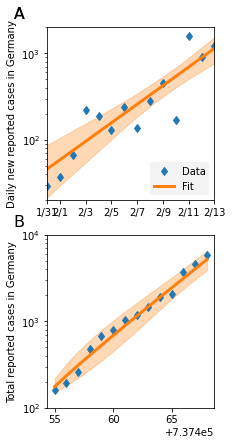

In [15]:
#Definitions
fig = plt.figure(figsize=(3, 7))
gs = fig.add_gridspec(2,1)


letter_size = 15
ci_location = [0.95,0.9]
alpha_texbox = 0.3
font_text = 10
ylabel_new = f"Daily new reported cases in Germany"
ylabel_cum = f"Total reported cases in Germany"

pos_letter = (-0.3, 1)
titlesize = 16
insetsize = ("25%", "50%")

new_c_ylim = [1, 10_000]
new_c_insetylim = [50, 17_000]


ax_cases_new = fig.add_subplot(gs[0])
ax_cases_total = fig.add_subplot(gs[1])

#Plots things
pos_letter = (-0.2, 1.05)

date_data_begin = datetime.date(2020,3,2)
date_data_end = datetime.date(2020,3,15)
date_range = pd.date_range(date_data_begin, date_data_end).to_numpy()

ax = ax_cases_new
time = np.arange(-len(cases_obs)+1, 0)
mpl_dates = conv_time_to_mpl_dates(time) 
start_date, end_date = mpl_dates[0], mpl_dates[-1]
ax.plot(mpl_dates, np.diff(cases_obs), 'd', markersize=6, label='Data')

percentiles = np.percentile(trace.new_cases_past, q=2.5, axis=0), np.percentile(trace.new_cases_past, q=97.5, axis=0)
ax.plot(mpl_dates, np.median(trace.new_cases_past, axis=0),color='tab:orange', label='Fit', lw=3)
ax.fill_between(mpl_dates, percentiles[0], percentiles[1], alpha=0.3, color='tab:orange')

ax.text(pos_letter[0], pos_letter[1], "A", transform=ax.transAxes, size=letter_size)
ax.xaxis.set_major_locator(matplotlib.dates.AutoDateLocator())
ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%-m/%-d'))
ax.set_xlim(start_date, end_date)
ax.set_xlim(start_date, end_date)
ax.set_yscale('log')
ax.set_ylim([20,2000])
ax.set_ylabel(ylabel_new)
ax.legend(loc="lower right")
ax.get_legend().get_frame().set_linewidth(0.0)
ax.get_legend().get_frame().set_facecolor("#F0F0F0")
#ax.set_ylim(new_c_ylim)

#ax.text(pos_letter[0], pos_letter[1], "B", transform=ax.transAxes, size=titlesize)

# ax.set_xlim(start_date, end_date)
# #format_date_xticks(ax)
# ax.yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(format_k))
# for label in ax.xaxis.get_ticklabels()[1::2]:
#     label.set_visible(False)
# ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%b %-d"))

ax = ax_cases_total
ax.plot(mpl_dates, cases_obs[1:], 'd', markersize=6, label='Data')
cum_cases = np.cumsum(trace.new_cases_past, axis=1) + cases_obs[0]
percentiles = np.percentile(cum_cases, q=2.5, axis=0), np.percentile(cum_cases, q=97.5, axis=0)
ax.plot(mpl_dates, np.median(cum_cases, axis=0),color='tab:orange', label='Fit (with 95% CI)', lw=3)
ax.fill_between(mpl_dates, percentiles[0], percentiles[1], alpha=0.3, color='tab:orange')



# ax.xaxis.set_major_locator(matplotlib.dates.AutoDateLocator())
# #ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%-m/%-d'))
#ax.set_xlim(start_date, end_date)
ax.set_yscale('log')
ax.set_ylabel(ylabel_cum)
ax.set_ylim([100,10000])

ax_cases_new.text(pos_letter[0], pos_letter[1], "A", transform=ax_cases_new.transAxes, size=titlesize)
ax_cases_total.text(pos_letter[0], pos_letter[1], "B", transform=ax_cases_total.transAxes, size=titlesize)

# format_date_xticks(ax_cases_new,True)
# format_date_xticks(ax_cases_total,True)



# #ax.legend()
# ax.text(pos_letter[0], pos_letter[1], "B", transform=ax.transAxes, size=letter_size)
# ax.xaxis.set_major_locator(matplotlib.dates.AutoDateLocator())
# ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%-m/%-d'))
# ax.set_xlim(start_date, end_date)

#plt.savefig("Fig1_A.png", bbox_inches="tight", pad_inches=0.1, dpi=300)

In [16]:
!pip install dvc

(25, 25)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:158: MatplotlibDeprecationWarning: Passing the minor parameter of set_yticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


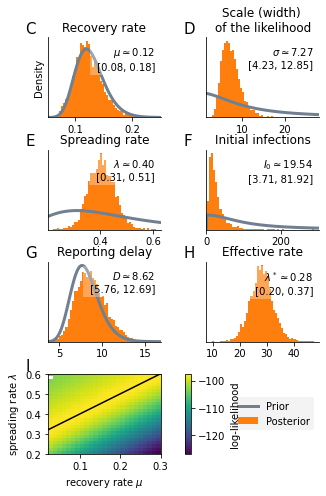

In [17]:
import dvc.api




fig = plt.figure(figsize=(4.75,7))
gs = fig.add_gridspec(4,2)


ax_param_recovery = fig.add_subplot(gs[0,0])
ax_param_width = fig.add_subplot(gs[0,1])
ax_param_infection  = fig.add_subplot(gs[1,0])
ax_param_izero = fig.add_subplot(gs[1,1])
ax_param_delay = fig.add_subplot(gs[2,0])
ax_param_effective_rate = fig.add_subplot(gs[2,1])
ax_likelihood = fig.add_subplot(gs[3,0])
ax_legend = fig.add_subplot(gs[3,1])

colors = ["#708090", "tab:orange"]

ax = ax_param_infection
ax.hist(trace.λ, bins=50, density=True, color='tab:orange',
        label='Posterior')
limits = ax.get_xlim()
x = np.linspace(*limits, num=100)
ax.plot(x, scipy.stats.lognorm.pdf(x, scale=0.4, s=0.5), label='Prior',
        color="#708090", linewidth=3)
ax.set_xlim(*limits)
# ax.set_ylabel('Density')
# ax.set_xlabel('Infection rate $\lambda$')
ax.set_title

text = r"$\lambda \simeq $" + print_median_CI_new(trace.λ, prec=2)
ax.text(ci_location[0], ci_location[1], text, horizontalalignment='right',verticalalignment='top', transform=ax.transAxes,  bbox=dict(facecolor='white', alpha=alpha_texbox,edgecolor='none'),fontsize=font_text)

#ax.legend(loc='upper right')

ax = ax_param_recovery
ax.hist(trace.μ, bins=50, density=True, color='tab:orange',
        label='Posterior')
limits = ax.get_xlim()
x = np.linspace(*limits, num=100)
ax.plot(x, scipy.stats.lognorm.pdf(x, scale=1/8, s=0.2), label='Prior',
        color="#708090", linewidth=3)
ax.set_xlim(*limits)
# ax.set_ylabel('Density')
# ax.set_xlabel('Recovery rate $\mu$')
text = r"$\mu \simeq $" + print_median_CI_new(trace.μ, prec=2)
ax.text(ci_location[0], ci_location[1], text, horizontalalignment='right',verticalalignment='top', transform=ax.transAxes,  bbox=dict(facecolor='white', alpha=alpha_texbox,edgecolor='none'),fontsize=font_text)

#ax.legend(loc='upper right')

ax = ax_param_effective_rate
ax.locator_params(nbins=5)
#bins = np.linspace(-0.11, 0.304, 200)
ax.hist((trace.λ - trace.μ)*100, bins=50, color='tab:orange')
# ax.set_xlabel('Eff. growth rate $\lambda^* = \lambda - \mu$ (%)')#\n'
#           #'inferred from data - from {} to {}'.format(date_data_begin.isoformat(), 
#           #                                            date_data_end.isoformat()))
# ax.set_ylabel('Number of Monte-Carlo samples')
text = r"$\lambda^* \simeq $" + print_median_CI_new((trace.λ - trace.μ), prec=0)
ax.text(ci_location[0], ci_location[1], text, horizontalalignment='right',verticalalignment='top', transform=ax.transAxes,  bbox=dict(facecolor='white', alpha=alpha_texbox,edgecolor='none'),fontsize=font_text)

ax = ax_param_delay
ax.hist(trace.delay, bins=50, density=True, color='tab:orange',
        label='Posterior')
limits = ax.get_xlim()
x = np.linspace(*limits, num=100)
ax.plot(x, scipy.stats.lognorm.pdf(x, scale=8, s=0.2), label='Prior',
        color="#708090", linewidth=3)
ax.set_xlim(*limits)
# ax.set_ylabel('Density')
# ax.set_xlabel('Delay $D$')
text = r"$D \simeq $" + print_median_CI_new(trace.delay, prec=1)
ax.text(ci_location[0], ci_location[1], text, horizontalalignment='right',verticalalignment='top', transform=ax.transAxes,  bbox=dict(facecolor='white', alpha=alpha_texbox,edgecolor='none'),fontsize=font_text)
#ax.legend(loc='upper right')

ax = ax_param_width
ax.hist(trace.σ_obs, bins=50, color='tab:orange', density=True, label='Posterior')
# ax.set_ylabel('Density')
# ax.set_xlabel("Scale factor $\sigma$ of likelihood")
limits = ax.get_xlim()
x = np.linspace(*limits, num=100)
ax.plot(x, scipy.stats.halfcauchy.pdf(x, scale=10), label='Prior',
        color="#708090", linewidth=3)
ax.set_xlim(*limits)
text = r"$\sigma \simeq $" + print_median_CI_new(trace.σ_obs, prec=1)
ax.text(ci_location[0], ci_location[1], text, horizontalalignment='right',verticalalignment='top', transform=ax.transAxes,  bbox=dict(facecolor='white', alpha=alpha_texbox,edgecolor='none'),fontsize=font_text)
#ax.legend(loc='upper right')


ax = ax_param_izero
ax.hist(trace.I_begin, bins=50, color='tab:orange', density=True, label='Posterior')
# ax.set_ylabel('Density')
# ax.set_xlabel('Number of infections at begin $I_0$')
limits = ax.get_xlim()
x = np.linspace(*limits, num=5000)
ax.plot(x, scipy.stats.halfcauchy.pdf(x, scale=100), label='Prior',
        color="#708090", linewidth=3)
ax.set_xlim(*limits)
ax.set_xlim(0)
text = r"$I_0 \simeq $" + print_median_CI_new(trace.I_begin, prec=0)
ax.text(ci_location[0], ci_location[1], text, horizontalalignment='right',verticalalignment='top', transform=ax.transAxes,  bbox=dict(facecolor='white', alpha=alpha_texbox,edgecolor='none'),fontsize=font_text)
#ax.legend(loc='lower right')


ax = ax_likelihood

ax.locator_params(nbins=5)
μ_arr = np.linspace(0.02, 0.3, 25)
#λ_arr = np.linspace(0.2, 0.6, 25)
#matrix = pickle.load(open('../../data/likelihood_matrix.pickled', 'rb'))
#matrix has [i,j] = [lambda,mu] with i rows -> rows for imshow are y
#so mu is on x axis...as we want to



matrix = pickle.loads(
    dvc.api.read(
 'likelihood_matrix.pickled',
    repo='https://github.com/ichironakamoto/COVID-19-2.git',
    mode='rb')
    )





im_mat = []
print(matrix.shape)
for row in matrix:
    im_mat.append([])
    for elem in row:
        if elem is not None:
            im_mat[-1].append(elem['logp'])
        else: im_mat[-1].append(np.nan)
#fig, ax1 = plt.subplots(1,1)
#im = ax1.imshow(im_mat, origin='lower', extent=[0.02, 0.3, 0.2, 0.6], aspect=0.5)
#plt.colorbar()
#heatmap = ax.imshow(im_mat, origin='lower', extent=[0.02, 0.3, 0.2, 0.6], aspect=0.71)
#heatmap = ax.imshow(im_mat, origin='lower', extent=[0.02, 0.3, 0.2, 0.6])
heatmap = ax.imshow(im_mat,origin='lower',extent=[0.02, 0.3, 0.2, 0.6], aspect='auto')

ax.plot(μ_arr, μ_arr+0.30, color='black')

#cbar = plt.colorbar(heatmap)
#cbar.set_label('log-likelihood')
ax.set_ylabel('spreading rate $\lambda$')
ax.set_xlabel('recovery rate $\mu$')

#ax.set_title('log-likelihood')

#ax.set_anchor('NW')

#Removes ylabels from D-I
ax_params = [ax_param_infection,ax_param_recovery, ax_param_effective_rate, ax_param_delay,ax_param_width,ax_param_izero]
for ax in ax_params:
  ax.set_yticks([], [])
  ax.set_ylabel('')
    
#Set legend    
ax = ax_legend
ax.set_axis_off()
ax.plot([], [], color=colors[0], linewidth=3, label="Prior")
ax.hist([], color=colors[1], label="Posterior")
ax.legend(loc="center right")
ax.get_legend().get_frame().set_linewidth(0.0)
ax.get_legend().get_frame().set_facecolor("#F0F0F0")

    
#Set letters
ax_param_recovery.text(pos_letter[0], pos_letter[1], "C", transform=ax_param_recovery.transAxes, size=letter_size)
ax_param_width.text(pos_letter[0], pos_letter[1], "D", transform=ax_param_width.transAxes, size=letter_size)
ax_param_infection.text(pos_letter[0], pos_letter[1], "E", transform=ax_param_infection.transAxes, size=letter_size)
ax_param_izero.text(pos_letter[0], pos_letter[1], "F", transform=ax_param_izero.transAxes, size=letter_size)
ax_param_delay.text(pos_letter[0], pos_letter[1], "G", transform=ax_param_delay.transAxes, size=letter_size)
ax_param_effective_rate.text(pos_letter[0], pos_letter[1], "H", transform=ax_param_effective_rate.transAxes, size=letter_size)
ax_likelihood.text(pos_letter[0], pos_letter[1], "I", transform=ax_likelihood.transAxes, size=letter_size)

#Set titles
ax_param_recovery.set_title('Recovery rate')
ax_param_width.set_title('Scale (width) \nof the likelihood')
ax_param_infection.set_title('Spreading rate')
ax_param_izero.set_title('Initial infections')
ax_param_delay.set_title('Reporting delay')
ax_param_effective_rate.set_title('Effective rate')
#ax_likelihood.set_title('log-likelihood')

#Removes splines
ax_param_recovery.set_ylabel('Density')
ax_list = [ax_param_recovery,ax_param_width, ax_param_infection, ax_param_izero, ax_param_delay, ax_param_effective_rate]
for ax in ax_list:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
plt.tight_layout()
plt.subplots_adjust(hspace=0.4)

#Adds colorbar after tight
pos = ax_likelihood.get_position()
cbaxes = fig.add_axes([0.55, pos.y0, 0.02, pos.y1-pos.y0])
cbar = fig.colorbar(heatmap, cbaxes)
cbar.set_label('log-likelihood')

plt.savefig("Fig1_B.png", bbox_inches="tight", pad_inches=0.1, dpi=300)